# Chapter 3: Journey to the Frozen Sea

In [ ]:
## Tracking Changes in Sea Ice

#### Objective

Reproduce figures from the C3S Climate Intelligence reports about sea ice. Specifically, we will reproduce figures from Sea ice section of the the [Monthly Climate Bulletins](https://climate.copernicus.eu/climate-bulletins) and [Climate Indicators](https://climate.copernicus.eu/climate-indicators/sea-ice).

#### Background

EUMETSAT is the European Organisation for the Exploitation of Meteorological Satellites. It's a global operational satellite agency at the heart of Europe that provides data, products, and support to a wide range of users in Europe and across the world.

The OSI SAF, or Ocean and Sea Ice Satellite Application Facility, is one of the specialized Satellite Application Facilities (SAFs) under EUMETSAT. The SAFs are dedicated centers of excellence for processing satellite data, and they focus on various thematic areas. OSI SAF, as its name suggests, concentrates on delivering operational products and services related to ocean and [sea ice](https://osi-saf.eumetsat.int/products/sea-ice-products).

In this tutorial we will work with different characteristics of global sea ice, specifically we will look at
* Sea Ice Extent
* Sea Ice Concentration
* Sea Ice Edge
* Sea Ice Type

All datasets are provided by the [MET Norway Thredds Service](https://thredds.met.no/thredds/osisaf/osisaf.html) of the Norwegian Meteorological Institute. This allow the user to download specific files directly using `xarray`. A selection of OSI SAF datasets are also made available through the Copernicus Climate Data and Marine Data Stores. In our case, we will access the data through the CDS when available and fallback to the MET Norway Thredds Service whenever the data is not available, which is only the case for the Sea Ice Index.


#### Definitions
taken from [OSI SAF website](https://osisaf-hl.met.no/v2p2-sea-ice-index)
* Sea Ice Extent (SIE) is defined as the area covered by a significant amount of sea ice, that is the area of ocean covered with more than 15% Sea Ice Concentration (SIC).
* Sea Ice Area (SIA) is the total ocean area covered by any amount of ice (0% SIC threshold).
* Sea Ice Concentration is the fractional coverage of a grid cell that is covered with sea ice.

At hemispherical scales, SIE is often reported with units of 10^6 sq km (millions square kilometers).

#### Datasets


- [ ] EUMETSAT OSI SAF Global Sea Ice Concentration CDR v3.0 (OSI-450-a): [Data and Documentation](https://osi-saf.eumetsat.int/products/osi-430-a)
- [ ] EUMETSAT OSI SAF Global Sea Ice Concentration ICDR v3.0 (OSI-430-a): [Data and Documentation](https://osi-saf.eumetsat.int/products/osi-450-a)
- [ ] C3S Sea Ice Edge and Type CDR v3.0: [Data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-edge-type?tab=form) | [Documentation](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-edge-type?tab=doc)
- [x] EUMETSAT OSI SAF Sea Ice Index v2.2: [Data](http://www.osi-saf.org/?q=content/sea-ice-index) | [Documentation](http://www.osi-saf.org/?q=content/sea-ice-index)


In [38]:
import os
import glob

import cdsapi
import xarray as xr
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import cmocean as cmo

import calendar

import matplotlib.dates as dates
import matplotlib.ticker as ticker

In [39]:
plt.style.use("../copernicus.mplstyle")

Set the reference period that defines the climatology of our records. Note that the format here is slightly different to the other notebooks so far. This is because we will rearrange the data into slightly different forms to facilitate the analysis and final visualisations.

In [50]:
REF_PERIOD = {'year': slice(1991, 2020)}

### Downloading the Data

In [41]:
path_to = {}  # dictionary containing [<variable> : <target folder>]

path_to.update({"concentration": "data/concentration/"})  
path_to.update({"extent": "data/extent/"})
path_to.update({"sea_ice_edge": "data/edge/"})
path_to.update({"sea_ice_type": "data/type/"})

for file, path in path_to.items():
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print("{:<15} --> {}".format(file, path))

concentration   --> data/concentration/
extent          --> data/extent/
sea_ice_edge    --> data/edge/
sea_ice_type    --> data/type/


### Sea Ice Extent
[Reference website](https://osi-saf.eumetsat.int/products/osi-420)

Daily sea ice extent (SIE) is available through the EUMETSAT OSI SAF Sea Ice Index v2.2 product, which containt sea ice extent and area.
Download daily index of sea ice extent (SIE) [here](https://thredds.met.no/thredds/osisaf/osisaf_seaiceindex.html):
* [Northern Hemisphere](https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/index/v2p2/nh/catalog.html?dataset=osisaf/met.no/ice/index/v2p2/nh/osisaf_nh_sie_daily.nc)
* [Southern Hemisphere](https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/index/v2p2/sh/catalog.html?dataset=osisaf/met.no/ice/index/v2p2/sh/osisaf_sh_sie_daily.nc)

In [42]:
sie_nh = xr.open_dataset("https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/nh/osisaf_nh_sie_daily.nc")
sie_sh = xr.open_dataset("https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/sh/osisaf_sh_sie_daily.nc")
sie_nh

<xarray.Dataset>
Dimensions:        (time: 16366, nv: 2)
Coordinates:
  * time           (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2023-08-15
    sic_threshold  float32 ...
    lat            float32 ...
    lon            float32 ...
Dimensions without coordinates: nv
Data variables:
    lat_bounds     (nv) float32 ...
    lon_bounds     (nv) float32 ...
    area           |S64 ...
    sie            (time) float64 ...
    source         (time) float64 ...
Attributes: (12/35)
    title:                   Daily Northern Hemisphere Sea Ice Extent from EU...
    product_id:              OSI-420
    product_name:            OSI SAF Sea Ice Index
    product_status:          demonstration
    version:                 v2p2
    summary:                 Time series of Daily Sea Ice Extent (SIE) for No...
    ...                      ...
    distribution_statement:  Free
    copyright_statement:     Copyright 2023 EUMETSAT
    references:              Product User Manual for OSI-420, Lavergne et al....
    featureType:             timeSeries
    DODS.strlen:             2
    DODS.dimName:            nchar

In [43]:
sie_nh = sie_nh.drop_vars(["lat", "lon", "sic_threshold"])
sie_sh = sie_sh.drop_vars(["lat", "lon", "sic_threshold"])

In [133]:
sie = xr.Dataset({
    "Arctic": sie_nh["sie"],
    "Antarctic": sie_sh["sie"],
})
sie

<xarray.Dataset>
Dimensions:    (time: 16366)
Coordinates:
  * time       (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2023-08-15
Data variables:
    Arctic     (time) float64 ...
    Antarctic  (time) float64 ...

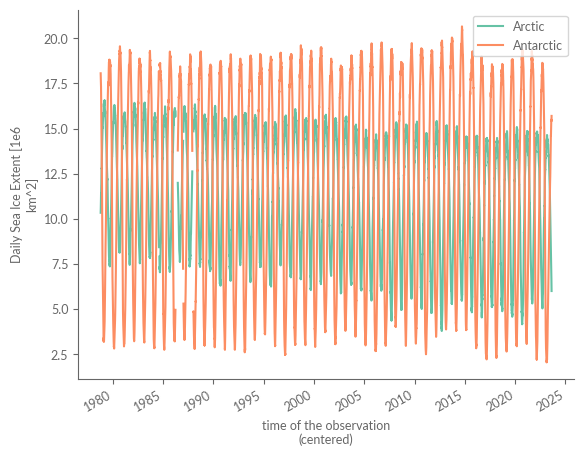

In [135]:
sie["Arctic"].plot(label="Arctic")
sie["Antarctic"].plot(label="Antarctic")
plt.legend()

In [136]:
sie["year"] = sie.time.dt.year
sie["dayofyear"] = sie.time.dt.dayofyear
sie = sie.set_index(time=["year", "dayofyear"]).unstack()
sie


<xarray.Dataset>
Dimensions:    (year: 46, dayofyear: 366)
Coordinates:
  * year       (year) int64 1978 1979 1980 1981 1982 ... 2020 2021 2022 2023
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    Arctic     (year, dayofyear) float64 nan nan nan nan nan ... nan nan nan nan
    Antarctic  (year, dayofyear) float64 nan nan nan nan nan ... nan nan nan nan

In [137]:
sie_clim_median = sie.sel(REF_PERIOD).median("year")

In [143]:
def create_line_plot(data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    # Plot the data as a line for each year
    xr.plot.line(data, ax=ax, x="dayofyear", color=".5", alpha=.5, add_legend=False)
    return fig, ax

def highlight_most_recent_year(ax, data):
    # Add the most recent year as a red line
    data.isel(year=-1).plot.line(ax=ax, x="dayofyear", color="r", alpha=.5, lw=4)
    # Add text with year at the most recent data point with the same color as the line
    most_recent_data = data.isel(year=-1).dropna('dayofyear').isel(dayofyear=-1)
    ax.text(
        most_recent_data.dayofyear + 5,
        most_recent_data.values,
        most_recent_data.year.values,
        color="r",
        alpha=.5,
        fontsize=14,
        weight="bold",
        va="center",
    )
    # Mark the most recent data with a red circle
    ax.plot(
        most_recent_data.dayofyear,
        most_recent_data.values,
        "o",
        color="r",
        alpha=.75,
        markersize=10,
        markeredgewidth=0,
    )

def center_labels_between_xticks(ax):
    # set y-ticks as integers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Set major x-ticks every 1 month
    ax.xaxis.set_major_locator(dates.MonthLocator())


    # Centering labels between ticks
    # 16 is a slight approximation since months differ in number of days.
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter("%b"))

    # Remove the minor tick lines
    ax.tick_params(axis="x", which="minor", tick1On=False, tick2On=False)

    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment("center")

In [144]:
region = 'Antarctic'

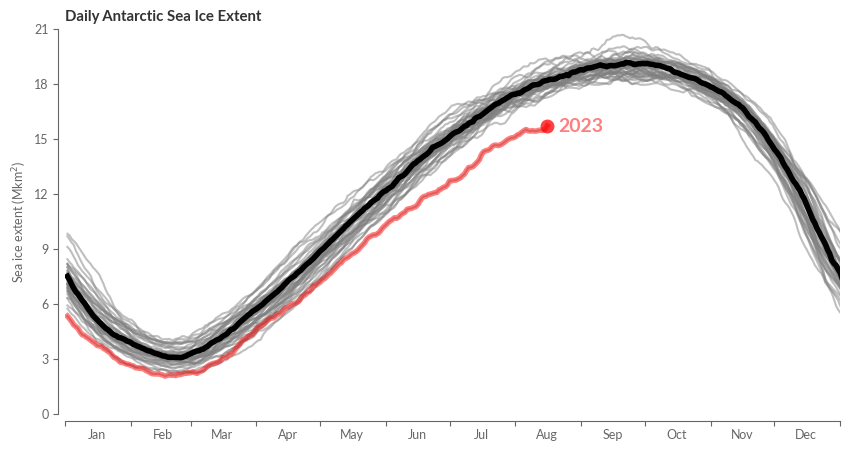

In [145]:
fig, ax = create_line_plot(sie[region])
# Add the median as a bold black line
sie_clim_median[region].plot(ax=ax, color="k", alpha=1, lw=4)
highlight_most_recent_year(ax, sie[region])
center_labels_between_xticks(ax)
ax.set_xlim(0, 365)
ax.set_ylim(0, 21)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent", weight='bold')
ax.set_ylabel("Sea ice extent (Mkm$^2$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()



In [146]:
sie_anomaly = sie - sie_clim_median

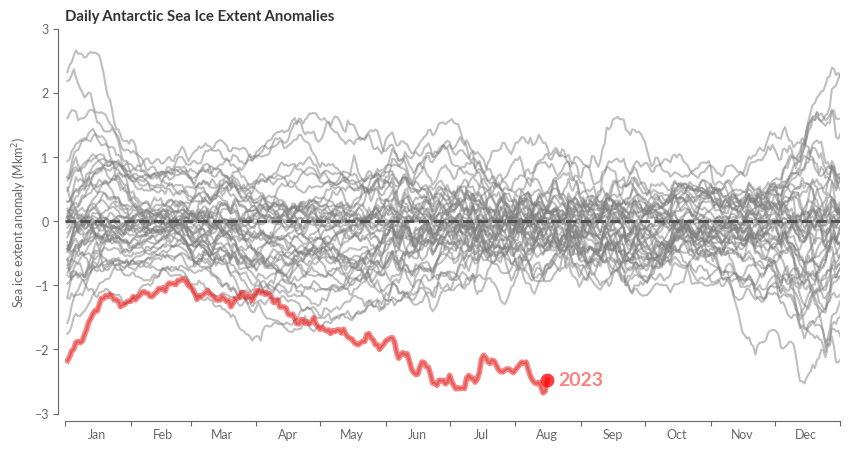

In [149]:
fig, ax = create_line_plot(sie_anomaly[region])
highlight_most_recent_year(ax, sie_anomaly[region])
center_labels_between_xticks(ax)
# Add center line
ax.axhline(0, color=".3", linewidth=0.5, ls='--', lw=2)
ax.set_xlim(0, 365)
ax.set_ylim(-3, 3)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent Anomalies", weight="bold")
ax.set_ylabel("Sea ice extent anomaly (Mkm$^2$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()


### Sea Ice Concentration
[CDS Data Access](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview)

In [70]:
most_recent_data = sie[region].isel(year=-1).dropna('dayofyear').isel(dayofyear=-1)
most_recent_data

<xarray.DataArray 'antarctic' ()>
array(15.6975)
Coordinates:
    year       int64 2023
    dayofyear  int64 227
Attributes:
    coverage_content_type:  physicalMeasurement
    comment:                Lake ice is not included
    standard_name:          sea_ice_extent
    long_name:              Daily Sea Ice Extent
    units:                  1e6 km^2

In [6]:
DAYS = ["{:02d}".format(d) for d in range(1, 32)]
MONTHS = ["{:02d}".format(m) for m in [2, 3, 9]]  # Note: only Feb, Mar and Sep are downloaded
YEARS = ["{:04d}".format(y) for y in range(1979, 2023)]


Note: We wonly download daily sea ice concentration for February, March and September which is sufficient to reproduce the Climate Indicator figures. However, you may be interested in other months too, so don"t hesitate to download more months if your environment provides sufficient space to store the data.

In [5]:
def download_sea_ice_concentration(client, year, month, save_to):
    client.retrieve(
        "satellite-sea-ice-concentration",
        {
            "version": "v2",
            "variable": "all",
            "format": "tgz",
            "origin": "eumetsat_osi_saf",
            "region": "northern_hemisphere",
            "cdr_type": ["cdr", "icdr"],
            "year": year,
            "month": month,
            "day": DAYS,
        },
        save_to,
    )
    # Unzip and then remove zipped file
    path_dir = os.path.dirname(save_to)
    os.system(f"tar -xzf {save_to} --directory {path_dir}")
    os.system(f"rm {save_to}")


<div class="alert alert-block alert-warning">
<b>Warning</b>: <br>
    The following cell will download about 33 GB. Please be sure that you have enough space available. Depending on your broadband internet connection this may take up to several hours.
</div>

In [8]:
c = cdsapi.Client(quiet=True, progress=False)

for year in tqdm(YEARS, desc="Overall progress"):
    for month in tqdm(MONTHS, desc="Year {}".format(year), leave=False):
        # Define the filename and the path to save the file
        filename = f"EUMETSAT_OSI_SAF_SIC_{year}_{month}.tar.gz"
        save_to = os.path.join(path_to["concentration"], filename)
        # Check if the extracted files already exist
        files_in_dir = glob.glob(f"data/concentration/*{year}{month}*.nc")
        skip_file = len(files_in_dir) > 0
        # Download the file if it doesn"t exist
        if not skip_file:
            download_sea_ice_concentration(c, year, month, save_to)

Overall progress:   0%|          | 0/44 [00:00<?, ?it/s]

Year 1979:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1980:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1981:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1982:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1983:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1984:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1985:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1986:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1987:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1988:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1989:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1990:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1991:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1992:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1993:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1994:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1995:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1996:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1997:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1998:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1999:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2000:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2001:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2002:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2003:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2004:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2005:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2006:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2007:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2008:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2009:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2010:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2011:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2012:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2013:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2014:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2015:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2016:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2017:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2018:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2019:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2020:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2021:   0%|          | 0/3 [00:00<?, ?it/s]

Year 2022:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
sic = xr.open_mfdataset("data/concentration/*.nc")
sic

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'cfgrib']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    As of time of writing, the Climate Data Store provides access to version 2 of the dataset and not the most recent version 3. If you need version 3, please consider downloading directly from <a href="https://osi-saf.eumetsat.int/products/osi-430-a">EUMETSAT OSI SAF official webpage</a>.
</div>

### Sea Ice Edge and Type
[CDS Data Access](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-edge-type?tab=overview)

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    As of time of writing, the Climate Data Store provides access to version 2 of the dataset and not the most recent version 3. If you need version 3, please consider downloading directly from <a href="https://osi-saf.eumetsat.int/products/osi-430-a">EUMETSAT OSI SAF official webpage</a>.
</div>

In [31]:
YEARS = ["{:04d}".format(y) for y in range(1979, 2023)]
DAYS = ["{:02d}".format(d) for d in range(1, 32)]

In [35]:
def download_c3s_sea_ice_type(client, variable, year, month, save_to):
    """Download sea ice edge/type for a given year and month from the CDS."""

    client.retrieve(
        "satellite-sea-ice-edge-type",
        {
            "format": "tgz",
            "variable": [variable],  # one of ["sea_ice_edge", "sea_ice_type",],  
            "region": "northern_hemisphere",
            "cdr_type": ["cdr", "icdr"],
            "year": year,
            "month": month,
            "day": DAYS,
            "version": "2_0",
        },
        save_to
    )
    # Unzip and then remove zipped file
    path_dir = os.path.dirname(save_to)
    os.system(f"tar -xzf {save_to} --directory {path_dir}")
    os.system(f"rm {save_to}")


def download_loop(client, variable, years, months):
    for year in tqdm(years, desc="Overall progress"):
        for month in tqdm(months, desc="Year {}".format(year), leave=False):
            # Define the filename and the path to save the file
            filename = f"EUMETSAT_OSI_SAF_{year}_{month}.tar.gz"
            save_to = os.path.join(path_to[variable], filename)
            # Check if the extracted files already exist
            path_dir = os.path.dirname(save_to)
            file_name_pattern = os.path.join(path_dir, f"*{year}{month}*.nc")
            # Get all files in the directory that match the pattern
            files_in_dir = glob.glob(file_name_pattern)
            file_already_exists = len(files_in_dir) > 0
            # Download the file if it doesn't exist
            if not file_already_exists:
                download_c3s_sea_ice_type(client, variable, year, month, save_to)

In [150]:
MONTHS = ["{:02d}".format(m) for m in [2, 3, 9]]  # Note: only Feb, Mar and Sep are downloaded
download_loop(client=c, variable='sea_ice_edge', years=YEARS, months=MONTHS)

Overall progress:   0%|          | 0/44 [00:00<?, ?it/s]

Year 1979:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1980:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1981:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1982:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1983:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1984:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1985:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1986:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1987:   0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
MONTHS = ["{:02d}".format(m) for m in [1, 2, 3]]  # Note: only Jan-Mar are downloaded
download_loop(client=c, variable='sea_ice_type', years=YEARS, months=MONTHS)

Overall progress:   0%|          | 0/44 [00:00<?, ?it/s]

Year 1979:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1980:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1981:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1982:   0%|          | 0/3 [00:00<?, ?it/s]

Year 1983:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
import urllib.request

path_to_file = 'data/test_tile.nc'
url = "https://thredds.met.no/thredds/fileServer/osisaf/met.no/reprocessed/ice/conc_cra_files/2022/12/ice_conc_sh_ease2-250_icdr-v3p0_202212311200.nc"
urllib.request.urlretrieve(url, path_to_file) 


FileNotFoundError: [Errno 2] No such file or directory: 'data/test_tile.nc'

In [ ]:
import xarray as xr
import urllib.request

path_to_file = 'data/sea_ice_extent.nc'
urllib.request.urlretrieve('https://thredds.met.no/thredds/fileServer/osisaf/met.no/ice/index/v2p1/nh/osisaf_nh_sie_monthly.nc', path_to_file) 

with xr.open_dataset(path_to_file) as sea_ice_extent:
    pass

sea_ice_extent


<xarray.Dataset>
Dimensions:        (time: 532, nv: 2)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-16 1979-02-16 ... 2023-04-16
    sic_threshold  float32 ...
    lat            float32 ...
    lon            float32 ...
Dimensions without coordinates: nv
Data variables:
    time_bounds    (time, nv) datetime64[ns] ...
    lat_bounds     (nv) float32 ...
    lon_bounds     (nv) float32 ...
    area           |S2 ...
    sie            (time) float64 ...
Attributes: (12/33)
    title:                   Monthly Mean Northern Hemisphere Sea Ice Extent ...
    product_id:              OSI-420
    product_name:            OSI SAF Sea Ice Index
    product_status:          demonstration
    version:                 v2p1
    summary:                 Time series of Monthly Mean Sea Ice Extent (SIE)...
    ...                      ...
    publisher_url:           met.no
    project:                 EUMETSAT OSI SAF
    distribution_statement:  Free
    copyright_statement:     Copyright 2023 EUMETSAT
    references:              Product User Manual for OSI-420, Lavergne et al....
    featureType:             timeSeries

In [2]:
extent = sea_ice_extent['sie']

label_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.0, 1.0, 'Arctic sea ice extent (million km$^2$)')

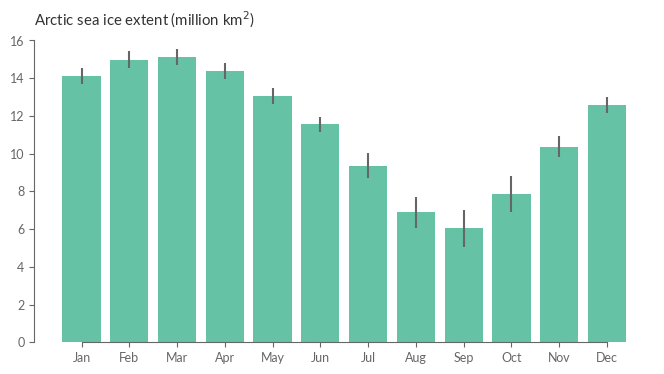

In [3]:
extent_clim = extent.sel(time=slice('1991', '2020'))
extent_clim_mean = extent_clim.groupby('time.month').mean()
extent_clim_stdev = extent_clim.groupby('time.month').std()

frac_ext = extent_clim_mean / extent_clim_mean.max()
import numpy as np
percentages = np.linspace(0, 120, 7)
yticks = percentages * extent_clim_mean.max().values / 100

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('../copernicus.mplstyle')

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.bar(extent_clim_mean.month, extent_clim_mean, yerr=extent_clim_stdev, ecolor='.4')
ax.set_xticks(extent_clim_mean.month)
ax.set_xticklabels(label_months)
sns.despine(ax=ax, trim=True)
ax.set_title('Arctic sea ice extent (million km$^2$)')



In [4]:
extent2 = extent.assign_coords(year=extent.time.dt.year, month=extent.time.dt.month)
# Stack year and month into a new multi-index
extent2 = extent2.set_index(time=['year', 'month'])



Text(0.0, 1.0, 'Arctic sea ice extent (million km$^2$)')

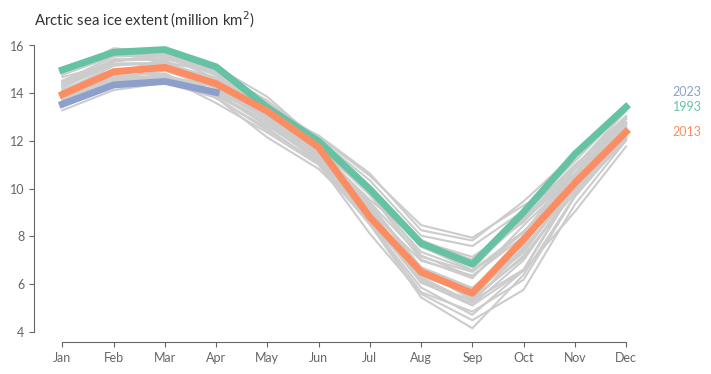

In [5]:
# get a different color for each year using a sequential colormap
prop_cycle_clrs = plt.rcParams['axes.prop_cycle']
colors = prop_cycle_clrs.by_key()['color']
special_years = [1993, 2013, 2023]
special_colors = {year: clr for year, clr in zip(special_years, colors[:len(special_years)])}

fig, ax = plt.subplots(1,1, figsize=(8,4))
for year in range(1991, 2024):
    extent2.sel(year=year).plot(ax=ax, color='.8')
    if year in special_years:
        clr = special_colors[year]
        extent2.sel(year=year).plot(ax=ax, color=clr, lw=5, label=year, zorder=3)

ax.set_xticks(extent_clim_mean.month)
ax.set_xticklabels(label_months)
import matplotx
matplotx.line_labels(ax=ax) # add legend as colored text next to the right end of the relevant line
sns.despine(ax=ax, trim=True)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Arctic sea ice extent (million km$^2$)')

In [6]:
extent_anom = (extent.groupby('time.month') - extent_clim_mean).groupby('time.month') / extent_clim_mean
is_march = extent_anom.month == 3
is_september = extent_anom.month == 9

anom_march = extent_anom.sel(time=is_march) * 100
anom_september = extent_anom.sel(time=is_september) * 100

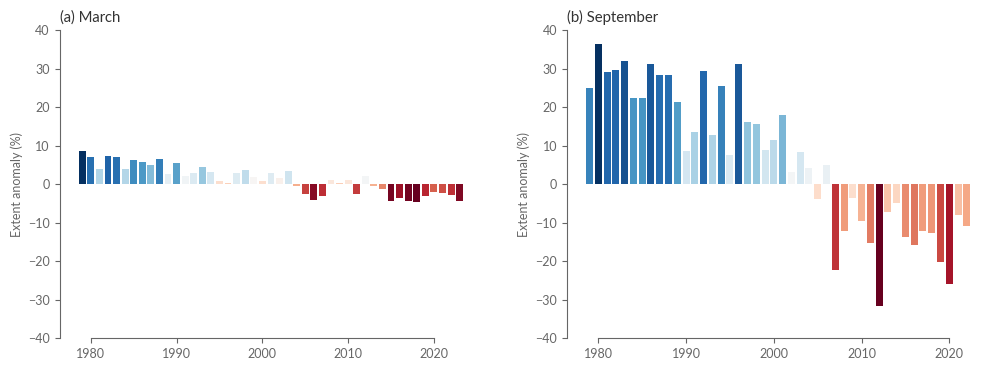

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns 
from string import ascii_lowercase as ABC 

subtitles = ['March', 'September']
cmap = sns.color_palette('RdBu', as_cmap=True)

norm_march = mcolors.Normalize(vmin=anom_march.min(), vmax=anom_march.max())
norm_september = mcolors.Normalize(vmin=anom_september.min(), vmax=anom_september.max())

clrs_march = [cmap(norm_march(val)) for val in anom_march.values]
clrs_september = [cmap(norm_september(val)) for val in anom_september.values]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(anom_march.time.dt.year, anom_march, color=clrs_march)
axes[1].bar(anom_september.time.dt.year, anom_september, color=clrs_september)
for ax, abc, title in zip(axes, ABC, subtitles):
    # ax.set_xticks(anom_march.time.dt.year[::5])
    # ax.set_xticklabels(anom_march.time.dt.year[::5])
    ax.set_ylim(-40, 40)
    ax.set_ylabel('Extent anomaly (%)')
    ax.set_xlabel('')
    ax.set_title('({}) {}'.format(abc, title))
    sns.despine(ax=ax, trim=True)

# Sea ice concentration

Concentration download link OSI SAF (EUMETSAT) OSI-430-a: https://osi-saf.eumetsat.int/products/osi-430-a
Then under **Data Access** in the row **Thredds** click on the second link. There navigate to the dataset refered to as "Aggregated Continuously Reprocessed (ICDR) Sea Ice Concentration v3.0 (OSI-430-a) for the Northern Hemisphere". On the final page copy the URL of the **OPENDAP Access**

In [13]:
url = "https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_nh_agg"
sic = xr.open_dataset(url)
sic

<xarray.Dataset>
Dimensions:                         (xc: 432, yc: 432, time: 940, nv: 2)
Coordinates:
  * xc                              (xc) float64 -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 5.388e+03 ... -5.388e+03
  * time                            (time) datetime64[ns] 2021-01-01T12:00:00...
    lat                             (yc, xc) float32 ...
    lon                             (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 ...
    time_bnds                       (time, nv) datetime64[ns] ...
    ice_conc                        (time, yc, xc) float64 ...
    raw_ice_conc_values             (time, yc, xc) float64 ...
    total_standard_uncertainty      (time, yc, xc) float64 ...
    smearing_standard_uncertainty   (time, yc, xc) float64 ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 ...
    status_flag                     (time, yc, xc) float32 ...
Attributes: (12/43)
    title:                     Interim Sea Ice Concentration Climate Data Rec...
    summary:                   This Interim Climate Data Record implements an...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_min:        16.62393
    ...                        ...
    Conventions:               CF-1.7,ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (Version 78, 21 Septemb...
    product_id:                osi-430-a
    product_name:              osi_saf_sea_ice_conc_climate_data_record_interim
    product_status:            operational
    doi:                       10.15770/EUM_SAF_OSI_0014

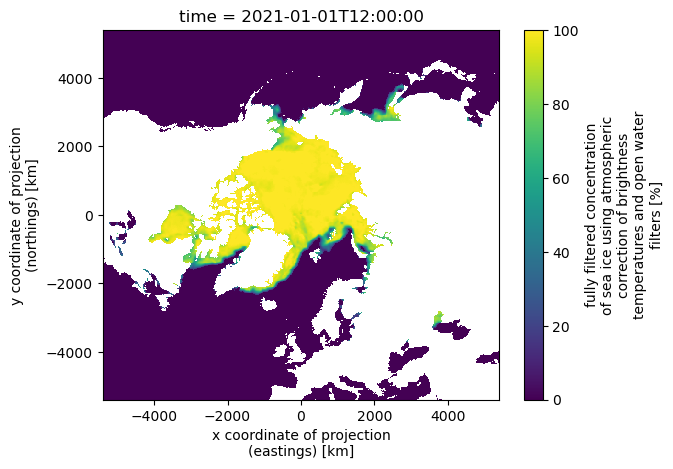

In [14]:
sic['ice_conc'].isel(time=0).plot()

In [15]:
url = "https://my.cmems-du.eu/thredds/dodsC/OSISAF-GLO-SEAICE_CONC_CONT_TIMESERIES-NH-LA-OBS?Lambert_Azimuthal_Grid,xc[0:1:431],yc[0:1:431],lat[0:1:0][0:1:0],lon[0:1:0][0:1:0],time[0:1:939],ice_conc[0:1:0][0:1:0][0:1:0]"
ds = xr.open_dataset(url)
ds

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!DOCTYPE^ html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd"> <head>  <title>Login</title>  <link href="http://marine.copernicus.eu/favicon.ico" rel="shortcut icon" type="image/x-icon" />  <!-- link rel="icon" type="image/png" href="http://myo-wp.techworks.ie/devel/templates/myocean/favicon.png" /-->>  <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />    <link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/content.css" media="all" />  <link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/content_cc.css" media="all" />  <link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/patch_content_cc.css" media="all" />  <link rel="stylesheet" type="text/css" href="/cas/newCss/css/cssmanager.php?version=4.0.2-1288885946&amp;files=/cas/newCss/css/myocean/print/print_003.c

OSError: [Errno -77] NetCDF: Access failure: 'https://my.cmems-du.eu/thredds/dodsC/OSISAF-GLO-SEAICE_CONC_CONT_TIMESERIES-NH-LA-OBS?Lambert_Azimuthal_Grid,xc[0:1:431],yc[0:1:431],lat[0:1:0][0:1:0],lon[0:1:0][0:1:0],time[0:1:939],ice_conc[0:1:0][0:1:0][0:1:0]'

In [8]:
import cads_toolbox
request = [
   "satellite-sea-ice-concentration",
   {
        'version': 'v2',
        'variable': 'all',
        'format': 'zip',
        'origin': 'eumetsat_osi_saf',
        'region': 'northern_hemisphere',
        'cdr_type': [
            'cdr', 'icdr',
        ],
        'year': list(range(1979, 2023)),
        'month': '09',
        'day': [
            # '01', '02', '03',
            # '04', '05', '06',
            '07',
        ],
   }
]
remote = cads_toolbox.catalogue.retrieve(*request)
data = remote.to_xarray()
data = data.compute()
sic = data['ice_conc']

2023-05-22 22:46:32,505 INFO Welcome to the CDS
2023-05-22 22:46:32,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-ice-concentration
2023-05-22 22:46:32,625 INFO Request is completed
2023-05-22 22:46:32,627 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data5/dataset-satellite-sea-ice-concentration-35962341-3dbe-4b63-9b9f-203794c4905e.zip to dataset-satellite-sea-ice-concentration-35962341-3dbe-4b63-9b9f-203794c4905e.zip (45.4M)
2023-05-22 22:47:05,365 INFO Download rate 1.4M/s   


In [10]:
sic

<xarray.DataArray 'ice_conc' (time: 40, yc: 432, xc: 432)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1979-09-07T12:00:00 ... 2022-09-07T12:00:00
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat      (time, yc, xc) float32 16.62 16.82 17.02 ... 17.02 16.82 16.62
    lon      (yc, xc) float32 -135.0 -135.1 -135.3 -135.4 ... 44.73 44.87 45.0
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_error status_flag
    comment:              this field is the primary sea ice concentration est...

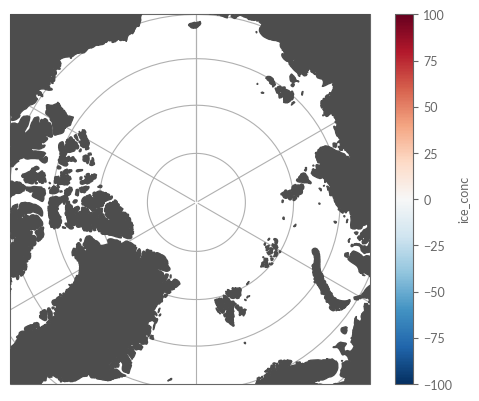

In [50]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
proj_polar = ccrs.NearsidePerspective(central_latitude=90, satellite_height=15785831)
proj_data = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)
diff = (sic.isel(time=-1) - sic.isel(time=0))

ax = plt.axes(projection=proj_polar)
ax.add_feature(cfeature.LAND, zorder=10, color='.3')
# ax.coastlines(zorder=10, color='r')
ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())

diff.plot.pcolormesh(ax=ax, zorder=50, cmap=plt.cm.RdBu_r, transform=proj_data)
ax.gridlines()


Somehow I cannot make the projections work.... I can plot land or the data, but not both. Do you see the error @NikosMastrantonas

# Sea ice edge type

In [245]:

request = [
   "satellite-sea-ice-edge-type",
   {
        'variable': 'sea_ice_edge',
        'region': 'northern_hemisphere',
        'cdr_type': 'cdr',
        'product_type': 'reanalysis',
        'year': list(range(1979, 2021)),
        'month': '03',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07',
        ],
        'version': '2_0',
        'time': '12:00',
        'format': 'zip',
   }
]
remote = cads_toolbox.catalogue.retrieve(*request)


In [247]:

da = remote.to_xarray()


2023-05-22 21:40:50,900 INFO Welcome to the CDS
2023-05-22 21:40:50,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-ice-edge-type
2023-05-22 21:40:51,052 INFO Request is completed
2023-05-22 21:40:51,054 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data6/dataset-satellite-sea-ice-edge-type-42a3a038-7a42-4ce7-be94-43a9c6e54e7f.zip to dataset-satellite-sea-ice-edge-type-42a3a038-7a42-4ce7-be94-43a9c6e54e7f.zip (28.6M)
2023-05-22 21:41:07,084 INFO Download rate 1.8M/s   


In [250]:
edge = da['ice_edge'].compute()


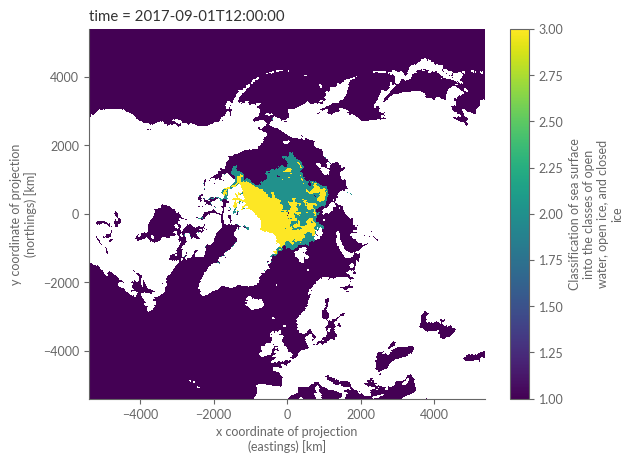

In [252]:
edge.isel(time=0).plot()